<a href="https://colab.research.google.com/github/JacekPardyak/tb-data-science-talks/blob/master/2022-09-29/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Spark and Sparklyr

In [1]:
if(!require(sparklyr)) install.packages('sparklyr')
library(sparklyr)
library(dplyr)
# install spark
spark_install(version = "3.1")
# Connecting to spark using spark_connect, on a local connection.
sc <- spark_connect(master = "local")
connection_is_open(sc)

Loading required package: sparklyr

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘sparklyr’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘htmlwidgets’, ‘config’, ‘forge’, ‘globals’, ‘r2d3’



Attaching package: ‘sparklyr’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] TRUE

In [5]:
library(tidyverse)
customers <- read_csv("https://raw.githubusercontent.com/JacekPardyak/tb-data-science-talks/master/2022-07-28/mall_customers.csv")
customers %>% glimpse()


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks sparklyr::filter(), stats::filter()
✖ purrr::invoke() masks sparklyr::invoke()
✖ dplyr::lag()    masks stats::lag()

Rows: 200 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Gender
dbl (4): CustomerID, Age, Annual Income (k$), Spending Score (1-100)

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 200
Columns: 5
$ CustomerID               <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…
$ Gender                   <chr> "Male", "Male", "Female", "Female", "Female",…
$ Age                      <dbl> 19, 21, 20, 23, 31, 22, 35, 23, 64, 30, 67, 3…
$ `Annual Income (k$)`     <dbl> 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 1…
$ `Spending Score (1-100)` <dbl> 39, 81, 6, 77, 40, 76, 6, 94, 3, 72, 14, 99, …


In [6]:
customers %>% summary()

   CustomerID        Gender               Age        Annual Income (k$)
 Min.   :  1.00   Length:200         Min.   :18.00   Min.   : 15.00    
 1st Qu.: 50.75   Class :character   1st Qu.:28.75   1st Qu.: 41.50    
 Median :100.50   Mode  :character   Median :36.00   Median : 61.50    
 Mean   :100.50                      Mean   :38.85   Mean   : 60.56    
 3rd Qu.:150.25                      3rd Qu.:49.00   3rd Qu.: 78.00    
 Max.   :200.00                      Max.   :70.00   Max.   :137.00    
 Spending Score (1-100)
 Min.   : 1.00         
 1st Qu.:34.75         
 Median :50.00         
 Mean   :50.20         
 3rd Qu.:73.00         
 Max.   :99.00         

In [ ]:
customers_sdf <- copy_to(sc, customers, "customers", overwrite = TRUE)

In [ ]:
# querying data with SQL
sql = "SELECT * FROM customers LIMIT 10"
sdf_sql(sc, sql)

# Source: spark<?> [?? x 5]
   CustomerID Gender   Age Annual_Income_k Spending_Score_1100
        <dbl> <chr>  <dbl>           <dbl>               <dbl>
 1          1 Male      19              15                  39
 2          2 Male      21              15                  81
 3          3 Female    20              16                   6
 4          4 Female    23              16                  77
 5          5 Female    31              17                  40
 6          6 Female    22              17                  76
 7          7 Female    35              18                   6
 8          8 Female    23              18                  94
 9          9 Male      64              19                   3
10         10 Female    30              19                  72

In [ ]:
# Pipelines with `dplyr` package but execute in Spark
customers_sdf %>%
  group_by(Gender) %>%
  summarise(
    count = n(), 
    age_av = mean(Age, na.rm = TRUE), 
    income_av = mean(Annual_Income_k, na.rm = TRUE),
    spendings_av = mean(Spending_Score_1100, na.rm = TRUE)
    )

# Source: spark<?> [?? x 5]
  Gender count age_av income_av spendings_av
  <chr>  <dbl>  <dbl>     <dbl>        <dbl>
1 Female   112   38.1      59.2         51.5
2 Male      88   39.8      62.2         48.5

In [ ]:
# Pipelines with `dplyr` package but execute in Spark and get result back to R
customers_sdf %>%
  group_by(Gender) %>%
  summarise(
    count = n(), 
    age_av = mean(Age, na.rm = TRUE), 
    income_av = mean(Annual_Income_k, na.rm = TRUE),
    spendings_av = mean(Spending_Score_1100, na.rm = TRUE)
    ) %>% collect()

Gender,count,age_av,income_av,spendings_av
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Female,112,38.09821,59.25000,51.52679
Male,88,39.80682,62.22727,48.51136


In [ ]:
# Feeling lost what Spark was asked for - show_query()
customers_sdf %>%
  group_by(Gender) %>%
  summarise(
    count = n(), 
    age_av = mean(Age, na.rm = TRUE), 
    income_av = mean(Annual_Income_k, na.rm = TRUE),
    spendings_av = mean(Spending_Score_1100, na.rm = TRUE)
    ) %>% show_query()

<SQL>
SELECT
  `Gender`,
  COUNT(*) AS `count`,
  AVG(`Age`) AS `age_av`,
  AVG(`Annual_Income_k`) AS `income_av`,
  AVG(`Spending_Score_1100`) AS `spendings_av`
FROM `customers`
GROUP BY `Gender`


In [ ]:
# the same code will work on the R tibble (note oryginal column names)
customers %>%
  group_by(Gender) %>%
  summarise(
    count = n(), 
    age_av = mean(Age, na.rm = TRUE), 
    income_av = mean(`Annual Income (k$)`, na.rm = TRUE),
    spendings_av = mean(`Spending Score (1-100)`, na.rm = TRUE)
    )

Gender,count,age_av,income_av,spendings_av
<chr>,<int>,<dbl>,<dbl>,<dbl>
Female,112,38.09821,59.25000,51.52679
Male,88,39.80682,62.22727,48.51136


In [ ]:
# transforming features, here binning rows
splits <- c(0, 33, 66, 100)
bucketized <- customers_sdf %>%
   ft_bucketizer(input_col = "Spending_Score_1100",
          output_col = "Spending_Score_Bucket", splits = splits)

 bucketized  # <- this is Spark table, to get R tibble use collect()

# Source: spark<?> [?? x 6]
   CustomerID Gender   Age Annual_Income_k Spending_Score_1100 Spending_Score_…¹
        <dbl> <chr>  <dbl>           <dbl>               <dbl>             <dbl>
 1          1 Male      19              15                  39                 1
 2          2 Male      21              15                  81                 2
 3          3 Female    20              16                   6                 0
 4          4 Female    23              16                  77                 2
 5          5 Female    31              17                  40                 1
 6          6 Female    22              17                  76                 2
 7          7 Female    35              18                   6                 0
 8          8 Female    23              18                  94                 2
 9          9 Male      64              19                   3                 0
10         10 Female    30              19                  72                 2


# Linear regression
Data Science starts here

In [ ]:
# split data into train and test. 
# First portion is shown to algorithm to train model. 
# The other remains hidden and used for model evaluation - comparing predicted and actual values
partitions <- customers_sdf %>%
  select(! one_of("CustomerID")) %>% 
  sdf_random_split(training = 0.5, test = 0.5, seed = 1099)
partitions  

$training
# Source: spark<?> [?? x 4]
   Gender   Age Annual_Income_k Spending_Score_1100
   <chr>  <dbl>           <dbl>               <dbl>
 1 Female    18              65                  48
 2 Female    19              63                  54
 3 Female    19              65                  50
 4 Female    23              18                  94
 5 Female    23              29                  87
 6 Female    23              54                  52
 7 Female    25              72                  34
 8 Female    27              40                  47
 9 Female    27              60                  50
10 Female    28              76                  40
# … with more rows

$test
# Source: spark<?> [?? x 4]
   Gender   Age Annual_Income_k Spending_Score_1100
   <chr>  <dbl>           <dbl>               <dbl>
 1 Female    20              16                   6
 2 Female    20              37                  75
 3 Female    21              30                  73
 4 Female    21         

In [ ]:
# train model
fit <- partitions$training %>%
  ml_linear_regression(Age ~ Spending_Score_1100)
fit
summary(fit)

Formula: Age ~ Spending_Score_1100

Coefficients:
        (Intercept) Spending_Score_1100 
         46.8789136          -0.1576537 

Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-27.0906  -9.0301   0.2696   8.0578  29.3732 

Coefficients:
        (Intercept) Spending_Score_1100 
         46.8789136          -0.1576537 

R-Squared: 0.07922
Root Mean Squared Error: 13.61


`geom_smooth()` using formula 'y ~ x'



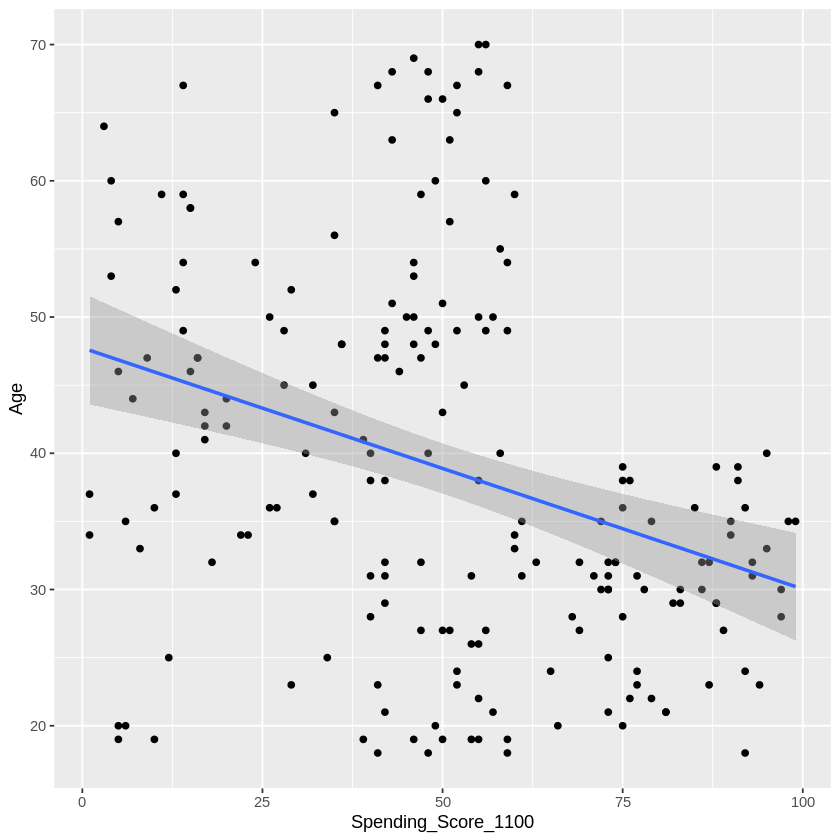

In [ ]:
customers_sdf %>% 
  ggplot() +
  aes(x = Spending_Score_1100, y = Age) +
  geom_point() +
  geom_smooth(method = "lm")

# Clustering with kmeans
Bridge with the previous DS Talk (Clustering)
https://github.com/JacekPardyak/tb-data-science-talks/blob/master/2022-08-25/notebook.ipynb

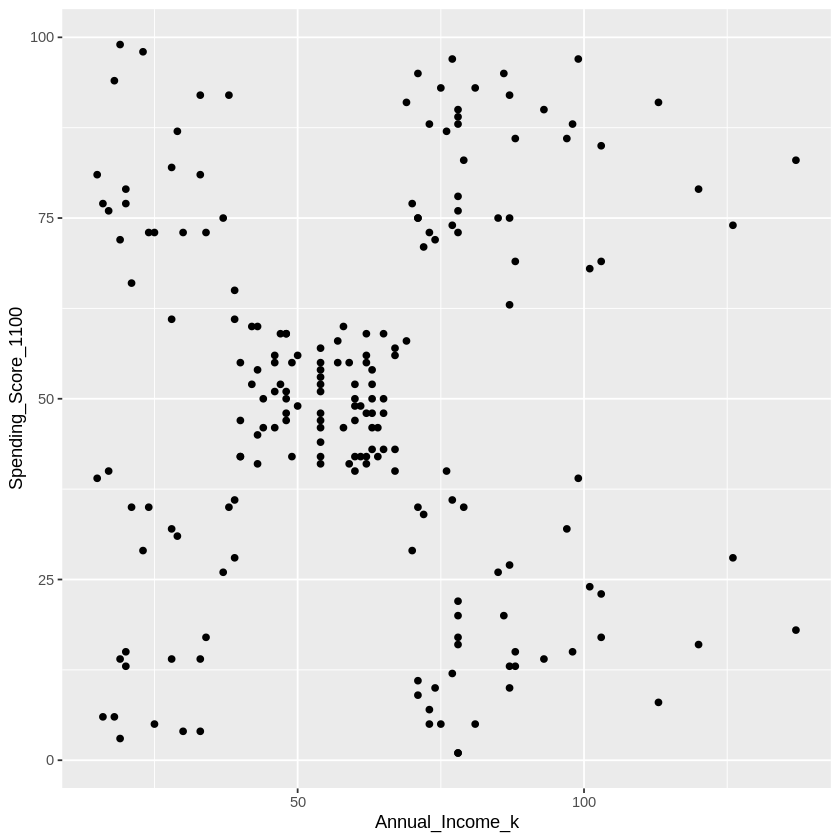

In [ ]:
customers_sdf %>% select("Annual_Income_k", "Spending_Score_1100") %>%
  ggplot() +
  aes(x = Annual_Income_k, y = Spending_Score_1100) +
  geom_point()

In [ ]:
kmeans_model <- customers_sdf  %>%
  ml_kmeans(k = 5, features = c("Annual_Income_k", "Spending_Score_1100"))

kmeans_model

K-means clustering with 5 clusters

Cluster centers:
  Annual_Income_k Spending_Score_1100
1        86.53846            82.12821
2        26.30435            20.91304
3        87.75000            17.58333
4        55.08750            49.71250
5        25.72727            79.36364

Within Set Sum of Squared Errors =  not computed.

In [ ]:
 # Model evaluation
 # silhouette_measure varies from -1 to 1, from bad to good.
 ml_compute_silhouette_measure(
       model = kmeans_model,
       dataset = customers_sdf,
       distance_measure = "squaredEuclidean")

[1] 0.7379329

# Association rules

In [19]:
connection_is_open(sc)

[1] TRUE

In [38]:
items_tbl <- customers %>% 
  copy_to(sc, df = ., "customers", overwrite = TRUE) %>%
  ft_bucketizer(
    input_col = "Age",
    output_col = "Age_",
    splits = c(18, 35, 53, 70)
  ) %>%
  ft_bucketizer(
    input_col = "Annual_Income_k",
    output_col = "Annual_Income_k_",
    splits = c(15, 56, 97, 137)
  ) %>%
  ft_bucketizer(
    input_col = "Spending_Score_1100",
    output_col = "Spending_Score_1100_",
    splits = c(1, 34, 67, 99)
  ) %>%
  select(CustomerID, Age_, Annual_Income_k_, Spending_Score_1100_, Gender) %>%
  mutate(Age_ = as.character(as.integer(Age_))) %>%
  mutate(Annual_Income_k_ = as.character(as.integer(Annual_Income_k_))) %>%
  mutate(Spending_Score_1100_ = as.character(as.integer(Spending_Score_1100_))) %>%
  pivot_longer(!CustomerID) %>% 
  mutate(item = paste(name, "=", value)) %>% 
  group_by(CustomerID) %>%
  summarise(items = collect_list(item))

items_tbl %>% collect()

CustomerID,items
<dbl>,<list>
1,"Age_ = 0 , Annual_Income_k_ = 0 , Gender = Male , Spending_Score_1100_ = 1"
3,"Age_ = 0 , Annual_Income_k_ = 0 , Gender = Female , Spending_Score_1100_ = 0"
4,"Age_ = 0 , Annual_Income_k_ = 0 , Gender = Female , Spending_Score_1100_ = 2"
6,"Age_ = 0 , Annual_Income_k_ = 0 , Gender = Female , Spending_Score_1100_ = 2"
7,"Age_ = 1 , Annual_Income_k_ = 0 , Gender = Female , Spending_Score_1100_ = 0"
12,"Age_ = 1 , Annual_Income_k_ = 0 , Gender = Female , Spending_Score_1100_ = 2"
13,"Age_ = 2 , Annual_Income_k_ = 0 , Gender = Female , Spending_Score_1100_ = 0"
14,"Age_ = 0 , Annual_Income_k_ = 0 , Gender = Female , Spending_Score_1100_ = 2"
16,"Age_ = 0 , Annual_Income_k_ = 0 , Gender = Male , Spending_Score_1100_ = 2"


In [39]:
fp_growth_model <- ml_fpgrowth(x = items_tbl,
                               min_confidence = 0.6,
                               min_support = 0.1)

ar <- ml_association_rules(fp_growth_model) %>% 
      collect() %>% 
      arrange(desc(confidence))
ar

antecedent,consequent,confidence,lift,support
<list>,<list>,<dbl>,<dbl>,<dbl>
"Spending_Score_1100_ = 2, Gender = Female",Age_ = 0,0.7575758,1.702417,0.125
Spending_Score_1100_ = 2,Age_ = 0,0.7368421,1.655825,0.210
Age_ = 2,Spending_Score_1100_ = 1,0.6944444,1.477541,0.125
"Age_ = 1 , Annual_Income_k_ = 0",Gender = Female,0.6896552,1.231527,0.100
"Annual_Income_k_ = 0, Gender = Male",Spending_Score_1100_ = 1,0.6388889,1.359338,0.115
"Age_ = 1 , Spending_Score_1100_ = 1",Gender = Female,0.6363636,1.136364,0.105
Age_ = 1,Gender = Female,0.6133333,1.095238,0.230
"Age_ = 0 , Spending_Score_1100_ = 1",Gender = Female,0.6111111,1.091270,0.110
"Annual_Income_k_ = 0, Age_ = 0",Gender = Female,0.6111111,1.091270,0.110


In [40]:
fi <- ml_freq_itemsets(fp_growth_model) %>% collect() %>% arrange(desc(freq))
fi

items,freq
<list>,<dbl>
Gender = Female,112
Spending_Score_1100_ = 1,94
Annual_Income_k_ = 1,94
Age_ = 0,89
Gender = Male,88
Annual_Income_k_ = 0,86
Age_ = 1,75
Spending_Score_1100_ = 2,57
"Spending_Score_1100_ = 1, Gender = Female",54
